In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from scipy import stats
from pathlib import Path, PureWindowsPath

In [236]:
%matplotlib inline

# Tiny Image KNN

In [238]:
def get_tiny_image(img,output_size):
    bounder = min([img.shape[0],img.shape[1]])
    img = np.resize(img,(bounder,bounder))
    w,h = output_size
    out = [[] for i in range(w)]
    w_bins = img.shape[0] // w
    h_bins = img.shape[1] // h

    for i,line in enumerate(img):
        for j in range(0,img.shape[0]-h_bins+1,h_bins):
            out[j//h_bins].append(np.mean(line[j:j+h_bins]))

    out2 = [[] for i in range(w)]
    for line in out:
        for j in range(0,img.shape[1]-w_bins+1,w_bins):
            out2[j//w_bins].append(np.mean(line[j:j+w_bins]))


    out2 = np.array(out2)
    return out2 - np.mean(out2)

In [239]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list

In [240]:
label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info('')

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


In [241]:
def predict_knn(feature_train, label_train, feature_test, k=1):
    nbrs = NearestNeighbors(n_neighbors=1).fit(feature_train)
    indices = nbrs.kneighbors(feature_test)[1]
    label_test_pred = np.array(label_train_list)[indices.flatten().astype(int)]
    return label_test_pred

In [248]:
def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    feature_train = [cv2.imread(path,0) for path in img_train_list]
    label_train = label_train_list
    feature_test = [cv2.imread(path,0) for path in img_test_list]
    
    if os.path.exists('./tiny_train.npy'):
        feature_train = np.load('./tiny_train.npy')
    else:
        feature_train = [get_tiny_image(img,(16,16)).flatten() for img in feature_train]
        np.save('tiny_train.npy', feature_train)
    
    if os.path.exists('./tiny_test.npy'):
        feature_test = np.load('./tiny_test.npy')
    else:
        feature_test = [get_tiny_image(img,(16,16)).flatten() for img in feature_test]
        np.save('tiny_test.npy', feature_test)
    
    preds = predict_knn(feature_train, label_train, feature_test, k=1)
    accuracy = sum(preds == np.array(label_test_list)) / len(label_test_list)
    
    labels_ = dict(zip(range(len(np.unique(label_test_list))), np.unique(label_test_list)))
    labels_inv = {v: k for k, v in labels_.items()}
    confusion = np.zeros((len(label_classes),len(label_classes)))
    for i,lab in enumerate(label_test_list):
        i_ = labels_inv[label_test_list[i]]
        j_ = labels_inv[preds[i]]
        confusion[i_][j_] += 1
    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [249]:
def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()

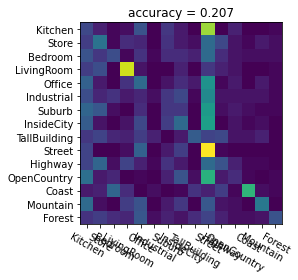

(array([[12.,  5.,  1.,  2., 14.,  0.,  9.,  4.,  0., 47.,  0.,  5.,  0.,
          0.,  1.],
        [10., 21.,  1.,  7.,  6.,  0.,  8.,  4.,  2., 19., 12.,  3.,  1.,
          4.,  2.],
        [14.,  9., 13.,  1.,  8.,  1.,  7.,  7.,  5., 19.,  7.,  3.,  2.,
          2.,  2.],
        [10., 13.,  0., 51.,  3.,  0.,  0.,  5.,  0.,  9.,  5.,  3.,  0.,
          0.,  1.],
        [17.,  4.,  0.,  8., 19.,  0.,  3.,  7.,  4., 28.,  1.,  4.,  0.,
          4.,  1.],
        [13.,  6.,  8.,  4.,  6.,  2.,  9., 12.,  1., 26.,  3.,  3.,  3.,
          3.,  1.],
        [18., 15.,  2.,  0.,  7.,  0.,  9.,  9.,  0., 30.,  2.,  4.,  2.,
          1.,  1.],
        [16.,  3.,  0.,  3., 12.,  0., 10., 19.,  0., 31.,  0.,  3.,  1.,
          2.,  0.],
        [ 9., 11.,  6.,  5., 10.,  5.,  0.,  4., 16., 11., 12.,  3.,  3.,
          5.,  0.],
        [11.,  0.,  0.,  2., 17.,  0.,  4., 10.,  0., 55.,  1.,  0.,  0.,
          0.,  0.],
        [11., 18.,  2., 11.,  5.,  1.,  8.,  4.,  0., 19., 1

In [250]:
classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

# BOW

In [12]:
def compute_dsift(img, stride, size):
    sift = cv2.xfeatures2d.SIFT_create()
    kps = []
    for i in range(0,img.shape[0],stride):
        for j in range(0,img.shape[1],stride):
            kps.append(cv2.KeyPoint(j,i,size))
    dense_feature = sift.compute(img, kps)
    return dense_feature[1]


In [13]:
def build_visual_dictionary(dense_feature_list, dic_size):
    pool = []
    for pic in dense_feature_list:
        for n in pic:
            pool.append(n)
            
    kmeans = KMeans(n_clusters=dic_size,n_init=12,max_iter=300)
    centers = kmeans.fit(pool)
    vocab = centers.cluster_centers_
    np.save('vocab.npy', vocab)

    return vocab

In [14]:
def compute_bow(feature, vocab):
    bow = [0 for i in range(vocab.shape[0])]
    nbrs = NearestNeighbors(n_neighbors=4).fit(vocab)
    for i,feat in enumerate(feature):
        bow[nbrs.kneighbors(feat.reshape(1, -1))[1][0][0]] += 1
        bow[nbrs.kneighbors(feat.reshape(1, -1))[1][0][1]] += 0.8
        bow[nbrs.kneighbors(feat.reshape(1, -1))[1][0][2]] += 0.6
        bow[nbrs.kneighbors(feat.reshape(1, -1))[1][0][3]] += 0.4
    bow /= np.sum(bow)
    
    return bow

In [15]:
import time as t

In [16]:
def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    ## 99 second runtime with saved matrices 
    
    feature_train = [cv2.imread(path,0) for path in img_train_list]
    feature_test = [cv2.imread(path,0) for path in img_test_list]

    stride,size = 15,15
    dic_size=64
    dense_feature_list_train = None
    dense_feature_list_test = None
    
    if os.path.exists('./vocab.npy'):
        vocab = np.load('./vocab.npy')
    else:
        dense_feature_list_train = [compute_dsift(pic,stride,size) for pic in feature_train]
        vocab = build_visual_dictionary(dense_feature_list_train, dic_size)
        np.save('vocab.npy', vocab)
        
    if os.path.exists('./feature_train.npy'):
        feature_train = np.load('./feature_train.npy')
    else:
        if not dense_feature_list_train:
            dense_feature_list_train = [compute_dsift(pic,stride,size) for pic in feature_train]
        feature_train = [compute_bow(img,vocab) for img in dense_feature_list_train]
        np.save('feature_train.npy', feature_train)
        
    if os.path.exists('./feature_test.npy'):
        feature_test = np.load('./feature_test.npy')
    else:
        if not dense_feature_list_test:
            dense_feature_list_test = [compute_dsift(pic,stride,size) for pic in feature_test]
        feature_test = [compute_bow(img,vocab) for img in dense_feature_list_test]
        np.save('feature_test.npy', feature_test) 

    ## Precictions
    preds = predict_knn(feature_train, label_train_list, feature_test, k=1)
    accuracy = sum(preds == np.array(label_test_list)) / len(label_test_list)

    labels_ = dict(zip(range(len(np.unique(label_test_list))), np.unique(label_test_list)))
    labels_inv = {v: k for k, v in labels_.items()}
    confusion = np.zeros((len(label_classes),len(label_classes)))
    for i,lab in enumerate(label_test_list):
        i_ = labels_inv[label_test_list[i]]
        j_ = labels_inv[preds[i]]
        confusion[i_][j_] += 1
    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

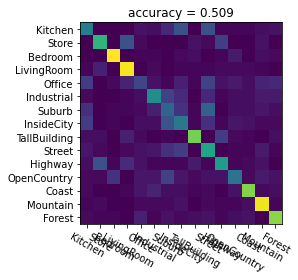

99.3513674736023


In [33]:
st = t.time()
classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)
end = t.time()
print(end-st)

## Classify SVM Bow

In [17]:
label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info('')

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


In [18]:
feature_train = [cv2.imread(path,0) for path in img_train_list]
feature_test = [cv2.imread(path,0) for path in img_test_list]

stride,size = 15,15
dic_size=64
dense_feature_list_train = None
dense_feature_list_test = None

if os.path.exists('./vocab.npy'):
    vocab = np.load('./vocab.npy')
else:
    dense_feature_list_train = [compute_dsift(pic,stride,size) for pic in feature_train]
    vocab = build_visual_dictionary(dense_feature_list_train, dic_size)
    np.save('vocab.npy', vocab)

if os.path.exists('./feature_train.npy'):
    feature_train = np.load('./feature_train.npy')
else:
    if not dense_feature_list_train:
        dense_feature_list_train = [compute_dsift(pic,stride,size) for pic in feature_train]
    feature_train = [compute_bow(img,vocab) for img in dense_feature_list_train]
    np.save('feature_train.npy', feature_train)

if os.path.exists('./feature_test.npy'):
    feature_test = np.load('./feature_test.npy')
else:
    if not dense_feature_list_test:
        dense_feature_list_test = [compute_dsift(pic,stride,size) for pic in feature_test]
    feature_test = [compute_bow(img,vocab) for img in dense_feature_list_test]
    np.save('feature_test.npy', feature_test) 

In [19]:
label_train = label_train_list

In [232]:
def predict_svm(feature_train, label_train, feature_test, n_classes):
    classes = np.unique(label_train)
    models = []
    label_train = np.array(label_train)
    for clas in classes:
        svm = LinearSVC(
                   dual=False,
                   C=150,
                   max_iter=40000,
                   )
        class_idxs = np.argwhere(np.where(np.array(label_train) == clas,1,0)).flatten()
        class_features = feature_train[class_idxs]
        class_labels = label_train[class_idxs]
        non_features = feature_train[np.argwhere(np.where(np.array(label_train) != clas,1,0)).flatten()]
        non_labels = np.array(['not' for i in range(non_features.shape[0])])

        features = np.concatenate((class_features,non_features))
        labels = np.concatenate((class_labels,non_labels))

        svm.fit(features,labels)
        models.append(svm)

    preds = []
    for point in feature_test:
        scores = []
        for model in enumerate(models):
            scores.append(model[1].decision_function(point.reshape(1, -1)))
        preds.append(classes[np.argmin(scores)])

    label_test_pred = preds

    return label_test_pred


In [233]:
preds = predict_svm(feature_train, label_train, feature_test, 2)
print(sum(np.array(preds) == label_test_list) / len(preds))

0.6493333333333333


In [253]:
def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    feature_train = [cv2.imread(path,0) for path in img_train_list]
    feature_test = [cv2.imread(path,0) for path in img_test_list]

    stride,size = 15,15
    dic_size=64
    dense_feature_list_train = None
    dense_feature_list_test = None

    if os.path.exists('./vocab.npy'):
        vocab = np.load('./vocab.npy')
    else:
        dense_feature_list_train = [compute_dsift(pic,stride,size) for pic in feature_train]
        vocab = build_visual_dictionary(dense_feature_list_train, dic_size)
        np.save('vocab.npy', vocab)

    if os.path.exists('./feature_train.npy'):
        feature_train = np.load('./feature_train.npy')
    else:
        if not dense_feature_list_train:
            dense_feature_list_train = [compute_dsift(pic,stride,size) for pic in feature_train]
        feature_train = [compute_bow(img,vocab) for img in dense_feature_list_train]
        np.save('feature_train.npy', feature_train)

    if os.path.exists('./feature_test.npy'):
        feature_test = np.load('./feature_test.npy')
    else:
        if not dense_feature_list_test:
            dense_feature_list_test = [compute_dsift(pic,stride,size) for pic in feature_test]
        feature_test = [compute_bow(img,vocab) for img in dense_feature_list_test]
        np.save('feature_test.npy', feature_test) 
        
    preds = predict_svm(feature_train, label_train_list, feature_test, 2)
    accuracy = sum(np.array(preds) == label_test_list) / len(preds)
    
    labels_ = dict(zip(range(len(np.unique(label_test_list))), np.unique(label_test_list)))
    labels_inv = {v: k for k, v in labels_.items()}
    confusion = np.zeros((len(label_classes),len(label_classes)))
    for i,lab in enumerate(label_test_list):
        i_ = labels_inv[label_test_list[i]]
        j_ = labels_inv[preds[i]]
        confusion[i_][j_] += 1
        
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

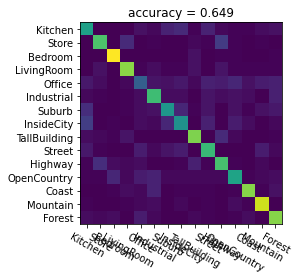

(array([[53.,  0.,  0.,  0.,  4.,  2.,  9., 11.,  1.,  9.,  2.,  1.,  1.,
          3.,  4.],
        [ 0., 67.,  0., 11.,  0.,  1.,  0.,  0.,  2.,  1., 16.,  1.,  0.,
          1.,  0.],
        [ 0.,  0., 93.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  1.,  1.,  0.,
          0.,  1.],
        [ 0.,  4.,  0., 77.,  1.,  3.,  1.,  1.,  4.,  0.,  5.,  1.,  1.,
          1.,  1.],
        [ 6.,  3.,  0.,  2., 28.,  5.,  4.,  6.,  2.,  8.,  7., 10.,  4.,
          7.,  8.],
        [ 2.,  1.,  0.,  1.,  3., 64.,  3.,  3.,  0.,  5.,  3.,  4.,  3.,
          0.,  8.],
        [12.,  0.,  0.,  1.,  3.,  4., 49., 10.,  1.,  5.,  0.,  4.,  1.,
          4.,  6.],
        [17.,  0.,  1.,  0.,  3.,  2., 10., 47.,  0.,  8.,  0.,  7.,  3.,
          0.,  2.],
        [ 3.,  2.,  1.,  5.,  0.,  0.,  0.,  0., 75.,  0., 11.,  2.,  0.,
          0.,  1.],
        [ 6.,  1.,  0.,  0.,  7.,  2.,  5.,  7.,  0., 63.,  0.,  0.,  0.,
          7.,  2.],
        [ 1., 12.,  3.,  2.,  3.,  0.,  0.,  1.,  8.,  1., 6

In [254]:
classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)